# LAB 6: Text classification with linear models

Objectives:
- Train and evaluate linear text classifiers using SGDClassifier
- Experiment with different feature extraction and training methods
- Some things to try:
  - [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn-linear-model-sgdclassifier)
  - [TFIDFVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn-feature-extraction-text-tfidfvectorizer)
  - [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn-decomposition-truncatedsvd)

In [1]:
import nltk
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

## Load and pre-process data

CCAT : CORPORATE/INDUSTRIAL  
ECAT : ECONOMICS  
GCAT : GOVERNMENT/SOCIAL  
MCAT : MARKETS 

In [2]:
train = pd.read_pickle("/data/rcv1-topics-train.pkl")
test = pd.read_pickle("/data/rcv1-topics-test.pkl")

In [3]:
train["topics"].value_counts()

CCAT    5896
MCAT    3281
GCAT    3225
ECAT    1073
Name: topics, dtype: int64

In [4]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return " ".join(t.norm_ for t in doc if t.is_alpha)

In [5]:
train["tokens"] = train["text"].progress_apply(tokenize)
test["tokens"] = test["text"].progress_apply(tokenize)

  0%|          | 0/13475 [00:00<?, ?it/s]

  0%|          | 0/3369 [00:00<?, ?it/s]

In [6]:
train.head(3)

,text,topics,tokens
0,NZ bonds close well bid ahead of key U.S. data...,MCAT,nz bonds close well bid ahead of key data at f...
1,Asia Product Swaps - Jet/gas oil regrade at di...,MCAT,asia product swaps jet gas oil regrade at disc...
2,U.S. public schools get a C report card in qua...,GCAT,public schools get a c report card in quality ...


-------

## MultinomialNB

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [8]:
mnb = make_pipeline(CountVectorizer(token_pattern=r"\S+"), MultinomialNB())
mnb.fit(train["tokens"], train["topics"])
predicted = mnb.predict(test["tokens"])
print(classification_report(test["topics"], predicted))

              precision    recall  f1-score   support

        CCAT       0.96      0.94      0.95      1475
        ECAT       0.92      0.65      0.76       268
        GCAT       0.93      0.98      0.95       806
        MCAT       0.90      0.97      0.94       820

    accuracy                           0.93      3369
   macro avg       0.93      0.88      0.90      3369
weighted avg       0.94      0.93      0.93      3369



In [9]:
from scipy.stats.distributions import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [10]:
search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "multinomialnb__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=10,
    n_jobs=-1,
    scoring="f1_macro",
)

search.fit(train["tokens"], train["topics"])

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(token_pattern='\\S+')),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2ad63582e380>,
                                        'countvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2ad63582e920>,
                                        'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2ad63582fbe0>},
                   scoring='f1_macro')

In [11]:
mnb.set_params(**search.best_params_)
mnb.fit(train["tokens"], train["topics"])
predicted = mnb.predict(test["tokens"])
print(classification_report(test["topics"], predicted))

              precision    recall  f1-score   support

        CCAT       0.97      0.95      0.96      1475
        ECAT       0.92      0.76      0.83       268
        GCAT       0.93      0.98      0.95       806
        MCAT       0.92      0.97      0.94       820

    accuracy                           0.94      3369
   macro avg       0.94      0.91      0.92      3369
weighted avg       0.95      0.94      0.94      3369



-------

## SGDClassifier

In [12]:
from sklearn.linear_model import SGDClassifier

In [13]:
sgd = make_pipeline(CountVectorizer(token_pattern=r"\S+"), SGDClassifier())
sgd.fit(train["tokens"], train["topics"])
sgd_predicted = sgd.predict(test["tokens"])
print(classification_report(test["topics"], sgd_predicted))

              precision    recall  f1-score   support

        CCAT       0.97      0.96      0.96      1475
        ECAT       0.89      0.87      0.88       268
        GCAT       0.96      0.98      0.97       806
        MCAT       0.96      0.96      0.96       820

    accuracy                           0.96      3369
   macro avg       0.94      0.94      0.94      3369
weighted avg       0.96      0.96      0.96      3369



### Hyperparameter search

In [14]:
sgd_search = RandomizedSearchCV(
    sgd,
    {
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=5,
    n_jobs=-1,
    scoring="f1_macro",
)

sgd_search.fit(train["tokens"], train["topics"])

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(token_pattern='\\S+')),
                                             ('sgdclassifier',
                                              SGDClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2ad635fdb5e0>},
                   scoring='f1_macro')

<Axes: xlabel='param_sgdclassifier__alpha', ylabel='mean_test_score'>

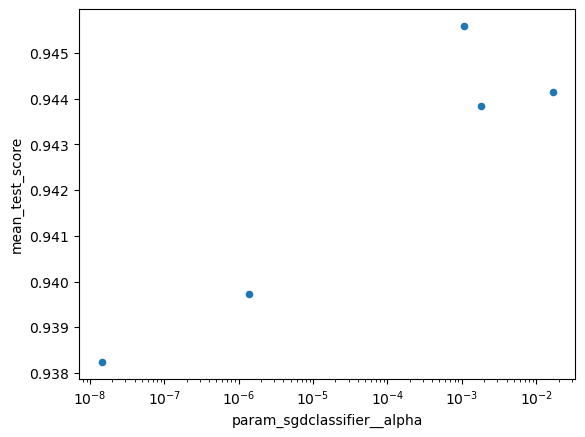

In [15]:
sgd_cv_results = pd.DataFrame(sgd_search.cv_results_)
sgd_cv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

In [16]:
sgd_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.776829,0.096030,0.340609,0.038272,0.001811,{'sgdclassifier__alpha': 0.0018110612221404086},0.951402,0.938436,0.946690,0.938701,0.943965,0.943839,0.004918,3
1,1.781960,0.100691,0.334847,0.041969,0.001079,{'sgdclassifier__alpha': 0.0010791525200861223},0.942022,0.943798,0.952131,0.946225,0.943750,0.945585,0.003536,1
2,1.936861,0.118145,0.302273,0.013669,0.0,{'sgdclassifier__alpha': 1.4382422568097675e-08},0.936052,0.941539,0.943627,0.939595,0.930373,0.938237,0.004657,5
3,1.776818,0.147050,0.338610,0.077028,0.016642,{'sgdclassifier__alpha': 0.01664158534672483},0.942684,0.946738,0.948408,0.946146,0.936713,0.944138,0.004154,2
4,1.874076,0.162121,0.288143,0.021402,0.000001,{'sgdclassifier__alpha': 1.357367011512013e-06},0.938075,0.941033,0.943686,0.939627,0.936225,0.939729,0.002545,4


In [17]:
sgd_rsearch = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__ngram_range": [(1, 2)],
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=5,
    n_jobs=-1,
    scoring="f1_macro",
)

sgd_rsearch.fit(train["tokens"], train["topics"])

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(token_pattern='\\S+')),
                                             ('sgdclassifier',
                                              SGDClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'countvectorizer__ngram_range': [(1,
                                                                          2)],
                                        'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2ad6486f6050>},
                   scoring='f1_macro')

In [18]:
sgd_rsearch.best_params_, sgd_rsearch.best_score_

({'countvectorizer__ngram_range': (1, 2),
  'sgdclassifier__alpha': 0.010780254556756371},
 0.9493310122820724)

<Axes: xlabel='param_sgdclassifier__alpha', ylabel='mean_test_score'>

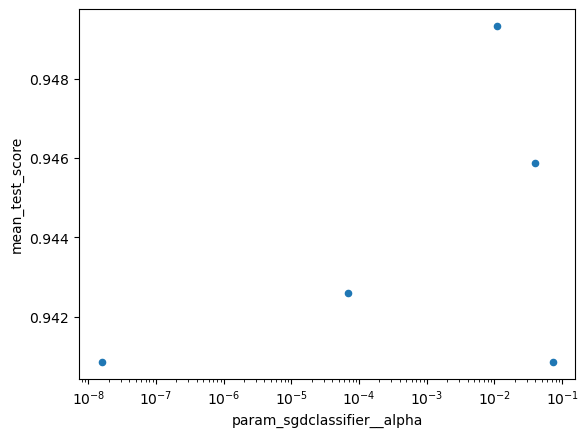

In [19]:
sgd_rcv_results = pd.DataFrame(sgd_rsearch.cv_results_)
sgd_rcv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

### Optimized model

In [20]:
sgd.set_params(countvectorizer__ngram_range=(1, 2), sgdclassifier__alpha=(1e-2))
sgd.fit(train["tokens"], train["topics"])
sgd_rpredicted = sgd.predict(test["tokens"])
print(classification_report(test["topics"], sgd_rpredicted))

              precision    recall  f1-score   support

        CCAT       0.97      0.97      0.97      1475
        ECAT       0.93      0.85      0.89       268
        GCAT       0.96      0.98      0.97       806
        MCAT       0.96      0.97      0.96       820

    accuracy                           0.96      3369
   macro avg       0.96      0.94      0.95      3369
weighted avg       0.96      0.96      0.96      3369



## SGD Classifier using Tfidf Vectorizer and Truncated SVD

In [21]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

**Tfidf Vecorizer:** Similar to Count Vectorizer followed by Tfidf Transformer.
defaults are norm l2 and use_idf True

In [22]:
sgd_tfidf_vector = make_pipeline(
    TfidfVectorizer(token_pattern=r"\S+"),
    TruncatedSVD(300, n_iter=25),
    SGDClassifier()
)

In [23]:
sgd_tfidf_vector.fit(train["tokens"], train["topics"])
sgd_tfidf_predicted = sgd_tfidf_vector.predict(test["tokens"])
print(classification_report(test["topics"], sgd_tfidf_predicted))

              precision    recall  f1-score   support

        CCAT       0.96      0.96      0.96      1475
        ECAT       0.93      0.78      0.85       268
        GCAT       0.94      0.98      0.96       806
        MCAT       0.95      0.95      0.95       820

    accuracy                           0.95      3369
   macro avg       0.94      0.92      0.93      3369
weighted avg       0.95      0.95      0.95      3369



**Hyper Parameter Search**

In [24]:
sgd_tfidf_search = RandomizedSearchCV(
    sgd_tfidf_vector,
    {
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=5,
    n_jobs=-1,
    scoring="f1_macro",
)

sgd_tfidf_search.fit(train["tokens"], train["topics"])

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer(token_pattern='\\S+')),
                                             ('truncatedsvd',
                                              TruncatedSVD(n_components=300,
                                                           n_iter=25)),
                                             ('sgdclassifier',
                                              SGDClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2ad6515a0910>},
                   scoring='f1_macro')

<Axes: xlabel='param_sgdclassifier__alpha', ylabel='mean_test_score'>

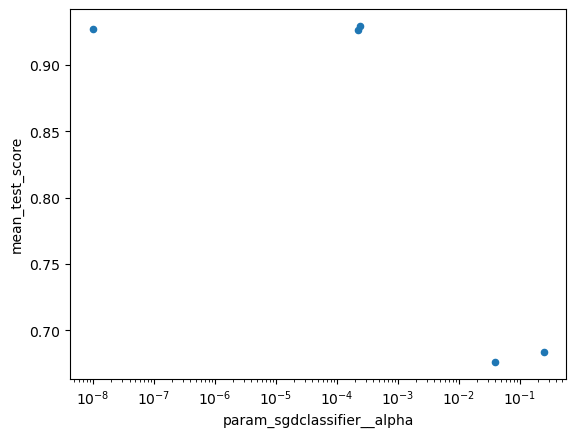

In [25]:
sgd_tfidf_cv_results = pd.DataFrame(sgd_tfidf_search.cv_results_)
sgd_tfidf_cv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

In [26]:
sgd_tfidf_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,91.732498,0.489244,0.512715,0.086564,0.000222,{'sgdclassifier__alpha': 0.0002224169319409769},0.925389,0.928116,0.915659,0.931333,0.930574,0.926214,0.005673,3
1,91.106152,0.520407,0.592932,0.166254,0.248249,{'sgdclassifier__alpha': 0.24824911244745435},0.659036,0.669010,0.710399,0.686331,0.692625,0.683480,0.018018,4
2,90.413562,0.432914,0.545148,0.150999,0.00024,{'sgdclassifier__alpha': 0.00023958568890003338},0.931943,0.935016,0.919151,0.931176,0.929435,0.929344,0.005407,1
3,90.475252,0.849506,0.551418,0.179285,0.0,{'sgdclassifier__alpha': 1.0008718613279746e-08},0.933669,0.928595,0.907174,0.935036,0.932279,0.927350,0.010314,2
4,78.342033,23.593489,0.552558,0.163658,0.038975,{'sgdclassifier__alpha': 0.038975128579681},0.672469,0.658439,0.674632,0.669523,0.705274,0.676067,0.015631,5


In [27]:
sgd_tfidf_search.best_params_, sgd_tfidf_search.best_score_

({'sgdclassifier__alpha': 0.00023958568890003338}, 0.9293442371810349)

param_sgdclassifier__alpha is best at 1e-6 and is good in range of 1e-8 to 1e-3. Hence changing the range to (1e-8, 1e-4).
Further searching the hyperparameters in tfidf vectorizer and truncatedsvd.

In [ ]:
sgd_tfidf_rsearch = RandomizedSearchCV(
    sgd_tfidf_vector,
    {
        "sgdclassifier__alpha": loguniform(1e-8, 1e-3),
        "tfidfvectorizer__min_df": randint(0, 10),
        "tfidfvectorizer__max_df": uniform(0.5, 0.5),
        "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2)],
        "truncatedsvd__n_components": [1, 10, 50, 100, 200, 300]
    },
    n_iter=25,
    n_jobs=-1,
    scoring="f1_macro",
)

sgd_tfidf_rsearch.fit(train["tokens"], train["topics"])

In [29]:
sgd_tfidf_rsearch.best_params_, sgd_tfidf_rsearch.best_score_

({'sgdclassifier__alpha': 3.3418296666242275e-06,
  'tfidfvectorizer__max_df': 0.814758083364463,
  'tfidfvectorizer__min_df': 4,
  'tfidfvectorizer__ngram_range': (1, 2),
  'truncatedsvd__n_components': 300},
 0.9433295017008841)

<Axes: xlabel='param_sgdclassifier__alpha', ylabel='mean_test_score'>

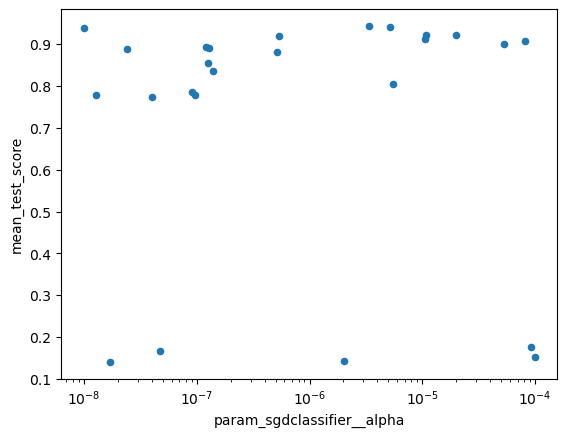

In [30]:
sgd_tfidf_rcv_results = pd.DataFrame(sgd_tfidf_rsearch.cv_results_)
sgd_tfidf_rcv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

In [31]:
sgd_tfidf_rcv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_tfidfvectorizer__max_df,param_tfidfvectorizer__min_df,param_tfidfvectorizer__ngram_range,param_truncatedsvd__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.541527,0.343296,0.322463,0.029794,0.000091,0.586994,3,"(1, 1)",1,{'sgdclassifier__alpha': 9.139475769782791e-05...,0.207299,0.152258,0.097881,0.274537,0.152168,0.176829,0.059866,21
1,20.307879,0.816071,0.715182,0.155062,0.0,0.96015,5,"(2, 2)",50,{'sgdclassifier__alpha': 1.4088716193590868e-0...,0.868080,0.862262,0.816840,0.816054,0.817676,0.836183,0.023746,15
2,50.865041,2.212960,0.685835,0.111977,0.000005,0.74809,5,"(1, 1)",300,{'sgdclassifier__alpha': 5.203765938775164e-06...,0.936239,0.939184,0.941614,0.945272,0.940267,0.940515,0.002965,2
3,98.760243,2.688073,1.683720,0.236641,0.000011,0.831556,2,"(1, 2)",100,{'sgdclassifier__alpha': 1.0708701948361573e-0...,0.914796,0.923939,0.921199,0.926299,0.927728,0.922792,0.004571,5
4,128.367810,5.756223,6.661780,6.119353,0.0,0.935556,1,"(1, 2)",50,{'sgdclassifier__alpha': 1.287203213018298e-07...,0.875004,0.891100,0.912473,0.895451,0.883891,0.891584,0.012535,11


**Optimized model**

In [33]:
sgd_tfidf_vector.set_params(**sgd_tfidf_rsearch.best_params_)
sgd_tfidf_vector.fit(train["tokens"], train["topics"])
sgd_tfidf_rpredicted = sgd_tfidf_vector.predict(test["tokens"])
print(classification_report(test["topics"], sgd_tfidf_rpredicted))

              precision    recall  f1-score   support

        CCAT       0.97      0.96      0.96      1475
        ECAT       0.94      0.81      0.87       268
        GCAT       0.93      0.99      0.96       806
        MCAT       0.96      0.95      0.95       820

    accuracy                           0.95      3369
   macro avg       0.95      0.93      0.94      3369
weighted avg       0.95      0.95      0.95      3369



**Observations:**

SFD Classifier performed better when using CountVectorizer, rather than TfidfVectorizer and TruncatedSVD, both before and after optimizing the model with the hyperparameters.

There was only s difference after tuning hyperparameters, 